# Install dependencies

In [1]:
!pip install -q streamlit

     |████████████████████████████████| 7.2MB 4.5MB/s 
     |████████████████████████████████| 112kB 42.9MB/s 
     |████████████████████████████████| 4.4MB 39.8MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
     |████████████████████████████████| 122kB 42.8MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.3.4 which is incompatible.


In [2]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -qq ngrok-stable-linux-amd64.zip

--2020-08-20 02:05:35--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.145.36.98, 3.225.89.236, 34.206.18.248, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.145.36.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  14.2MB/s    in 0.9s    

2020-08-20 02:05:36 (14.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]



In [3]:
!pip install efficientnet_pytorch
!pip install bunch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=9918a318f1e95c8cb718b2e8bea34288615cd20313e51ef866c3612d51c2befe
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch
  Created wheel for bunch: filename=bunch-1.0.1-cp36-none-any.whl size=7076 sha256=d3ff2ef538e7f850901ca46b93243a159ad11cc579ca1f0d686fe55faebf5a8f
  Stored in directory: /root/.cache/pip/wheels/56/0f/19/fbbf81e5764e6d8b74501c4357a88c14c94466ec777c03734c
Successfully built bunch


In [4]:
!gdown --id '1NeItjRYE6vXm1XXw750SeGf_mxgO7_59'
!unzip -qq configs.zip

Downloading...
From: https://drive.google.com/uc?id=1NeItjRYE6vXm1XXw750SeGf_mxgO7_59
To: /content/configs.zip
6.56MB [00:00, 39.8MB/s]


In [5]:
!gdown --id '1mwfsbIFWcvIpJS-Mes049kv-TwUztf30'
!unzip -qq model.zip

Downloading...
From: https://drive.google.com/uc?id=1mwfsbIFWcvIpJS-Mes049kv-TwUztf30
To: /content/model.zip
160MB [00:01, 90.5MB/s]


In [6]:
!nvidia-smi

Thu Aug 20 02:06:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Put your code inside `util` variable
Complete the code in your local and then put it in here.

In [7]:
#@title Utilization
#@markdown Run this cell to create utils.py.
#@markdown Add your code to 2 functions called `create_clahe` and `create_vessel`.

util = '''
from efficientnet_pytorch import EfficientNet
from albumentations import Compose, Resize, Normalize
import cv2
import torch.nn as nn
import torch
import numpy as np
from keras.models import model_from_json
from configs.utils.img_utils import get_test_patches,pred_to_patches,recompone_overlap
from configs.utils.config_utils import process_config


config = process_config("./configs/segmention_config.json")
vessel_model = model_from_json(open("./configs/VesselNet_architecture.json").read())
vessel_model.load_weights("./configs/VesselNet_best_weights.h5")

class Cooker(object):
  def __init__(self, resolution=240, p=1, tol=7):
    self.alb_ingstance = Compose([Resize(resolution,resolution),Normalize()], p=1)
    self.tol = tol

  def crop_image_from_gray(self, img, tol=None):
    tol = tol if tol else self.tol

    if img.ndim == 2:
      mask = img > tol
      return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
      gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      mask = gray_img > tol

      check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
      if (check_shape == 0):  # image is too dark so that we crop out everything,
        return img  # return original image
      else:
        img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
        img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
        img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
        img = np.stack([img1, img2, img3], axis=-1)
      return img

  def agu_val(self, img):
    return self.alb_ingstance(image=img)['image']

  def __call__(self, img):
    if type(img) == list:
      return [self(image) for image in img]
    # img = self.crop_image_from_gray(img)
    img = self.agu_val(img)
    return torch.from_numpy(img.transpose((2, 0, 1))).float().unsqueeze(0)  

class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()
    self.modelA = EfficientNet.from_pretrained('efficientnet-b3', num_classes=8)
    self.modelB = EfficientNet.from_pretrained('efficientnet-b3', num_classes=8)

    self.drop = nn.Dropout(0.3)
    self.out2 = nn.Linear(1536, 8)
    self.load_state()

  def load_state(self,
                 clahe_path='./model/clahe.pth',
                 vessel_path='./model/vessel.pth',
                 combine_path='./model/final.pth'
                 ):
    self.modelA.load_state_dict(
      torch.load(clahe_path)['model_state_dict']
    )
    print("Loaded weights from", clahe_path)

    self.modelB.load_state_dict(
      torch.load(vessel_path)['model_state_dict']
    )
    print("Loaded weights from", vessel_path)
    
    self.load_state_dict(torch.load(combine_path))
    print("Loaded weights from", combine_path)

  def forward(self, x1, x2):
    x1 = self.modelA.extract_features(x1)
    x2 = self.modelB.extract_features(x2)
    
    x1 = nn.AdaptiveAvgPool2d((1, 1))(x1)
    x2 = nn.AdaptiveAvgPool2d((1, 1))(x2)
    x1 = x1.view(1,1536)
    x2 = x2.view(1,1536)
    x = x1+x2    
    sigmoid = torch.sigmoid(x)
    multi = torch.mul(sigmoid,x2)
    x = multi + x1
    x = self.drop(x)
    x = x.flatten()
    x = self.out2(x)
    return torch.sigmoid(x)

def predict(model, l_clahe, l_vessel, r_clahe=None, r_vessel=None, device='cuda'):
  model.to(device)
  l_prediction = model(l_clahe.to(device), l_vessel.to(device)).cpu().detach().numpy()
  
  if r_clahe is not None and r_vessel is not None:
    r_prediction = model(r_clahe.to(device), r_vessel.to(device)).cpu().detach().numpy()
    return np.where(l_prediction > r_prediction, l_prediction, r_prediction)
  return l_prediction

def crop_image(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if (check_shape == 0):  # image is too dark so that we crop out everything,
            return img  # return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img
        
def create_clahe(img):
    """Function to create and return clahe image

        Parameter
        ---------
        img : Image or numpy.array
            A PIL Image object or image in numpy.array

        Return
        ------
        A PIL Image object or numpy.array image
    """
    dim = (240, 240)
    img = crop_image(img)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(4, 4))
    for i in range(3):
        img[:, :, i] = clahe.apply((img[:, :, i]))
    print('clahe:',img.shape)
    return img

def create_vessel(img, model=vessel_model):
    """Function to create and return vessel image

        Parameter
        ---------
        img : Image or numpy.array
            A PIL Image object or image in numpy.array

        Return
        ------
        A PIL Image object or numpy.array image
    """
    dim = (240, 240)
    img = crop_image(img)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    orgImg_temp=img
    orgImg=orgImg_temp[:,:,1]*0.75+orgImg_temp[:,:,0]*0.25
    height,width=orgImg.shape[:2]
    orgImg = np.reshape(orgImg, (height,width,1))
    patches_pred,new_height,new_width,adjustImg=get_test_patches(orgImg,config)
    predictions = model.predict(patches_pred, batch_size=32, verbose=1)
    pred_patches=pred_to_patches(predictions,config)
    pred_imgs=recompone_overlap(pred_patches,config,new_height,new_width)
    pred_imgs=pred_imgs[:,0:height,0:width,:]
    adjustImg=adjustImg[0,0:height,0:width,:]
    print(adjustImg.shape)
    probResult=pred_imgs[0,:,:,0]
    img = (probResult*255).astype(np.uint8)
    img = np.stack((img,)*3, axis=-1)
    return img
'''

with open("utils.py", 'w') as f:
  f.write(util)

In [8]:
#@title Main streamlit app
#@markdown You don't need to edit this file any more.
code = '''
import numpy as np
import pandas as pd
import streamlit as st
import cv2
import matplotlib.pyplot as plt
from utils import NeuralNet, Cooker, predict, create_clahe, create_vessel


##############################
# code start from here
# some configs
st.set_option('deprecation.showfileUploaderEncoding', False)

# cpu or cuda
device = 'cuda'

# label of diseases
labels = [
    "Normal",
    "Diabetes",
    "Glaucoma",
    "Cataract",
    "AMD",
    "Hypertension",
    "Myopia",
    "Other diseases/abnormalities"
]

#init fortune teller
@st.cache
def func(Cooker, NeuralNet):
  cooker = Cooker()
  x_model = NeuralNet()
  x_model.eval()
  return cooker, x_model
  
cooker, x_model = func(Cooker, NeuralNet)

left_img = left_fundus = None
right_img = right_fundus = None
fundus_imgs = []
fundus_caps = []
fundus_imgs_after_l = []
fundus_caps_after_l = []
fundus_imgs_after_r = []
fundus_caps_after_r = []
model_input_holder = {
    'left': None,
    'right': None
}

st.sidebar.header('Choose fundus images of patient.')
left_fundus_img = st.sidebar.file_uploader("Choose left fundus image", type='jpg')
right_fundus_img = st.sidebar.file_uploader("Choose right fundus image", type='jpg')

if left_fundus_img:
    left_img = np.frombuffer(left_fundus_img.read(), np.uint8)
    left_img = cv2.imdecode(left_img, cv2.IMREAD_COLOR)
    fundus_imgs.append(left_img)
    fundus_caps.append("Left fundus")
    left_fundus = True

if right_fundus_img:
    right_img = np.frombuffer(right_fundus_img.read(), np.uint8)
    right_img = cv2.imdecode(right_img, cv2.IMREAD_COLOR)
    fundus_imgs.append(right_img)
    fundus_caps.append("Right fundus")
    right_fundus = True

if left_fundus or right_fundus:
    "## Fundus images of patient"
    st.image(fundus_imgs, caption=fundus_caps, width=330, channels='BGR')

st.sidebar.header('Preprocess images by creating clahe and vessel images from input.')

pre_process = st.sidebar.button("Create CLAHE & Vessel images")

if pre_process and (left_fundus or right_fundus):
    "## Process left fundus image:"
    if left_fundus:
        l_clahe = create_clahe(left_img)
        fundus_imgs_after_l.append(l_clahe)
        fundus_caps_after_l.append("Left clahe")
        l_vessel = create_vessel(left_img)
        fundus_imgs_after_l.append(l_vessel)
        fundus_caps_after_l.append("Left vessel")
        st.image(fundus_imgs_after_l, caption=fundus_caps_after_l, width=330, channels='BGR')

        model_input_holder['left'] = cooker([l_clahe, l_vessel])

    '## Process right fundus image'
    if right_fundus:
        r_clahe = create_clahe(right_img)
        fundus_imgs_after_r.append(r_clahe)
        fundus_caps_after_r.append("Right clahe")
        r_vessel = create_vessel(right_img)
        fundus_imgs_after_r.append(r_vessel)
        fundus_caps_after_r.append("Right vessel")
        st.image(fundus_imgs_after_r, caption=fundus_caps_after_r, width=330, channels='BGR')

        model_input_holder['right'] = cooker([r_clahe, r_vessel])
    
    "## Result"
    if left_fundus:
        y_p = predict(x_model, *model_input_holder['left'], device=device)
    elif right_fundus:
        y_p = predict(x_model, *model_input_holder['right'], device=device)
    else:
        y_p = predict(x_model, *model_input_holder['left'], *model_input_holder['right'], device=device)

    plt.barh(labels, y_p)
    st.pyplot()
'''

with open("life_vest.py", 'w') as f:
  f.write(code)

# Do do do

In [9]:
!cp ngrok ngrrrok
!pkill ngrrrok
get_ipython().system_raw('./ngrrrok http 8501 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Open this link in your browser:', json.load(sys.stdin)['tunnels'][0]['public_url'])"

Open this link in your browser: https://ba3e66090ea0.ngrok.io


In [10]:
!streamlit run life_vest.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.205.67.9:8501

2020-08-20 02:06:28.819854: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-08-20 02:06:30.451407: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-08-20 02:06:30.512703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-08-20 02:06:30.513501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-08-20 02:06:30.513565: I tensorflow/stream_executor/platform/default/dso_lo

## Bella Ciao
[![Believer](http://img.youtube.com/vi/9ao4FEaDGhQ/0.jpg)](https://www.youtube.com/watch?v=9ao4FEaDGhQ)


# Test

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from utils import NeuralNet, Cooker, predict, create_clahe, create_vessel

In [ ]:
l_img = cv2.imread('/content/drive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/data/test_one/original/0_left.jpg')
r_img = cv2.imread('/content/drive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/data/test_one/original/0_right.jpg')

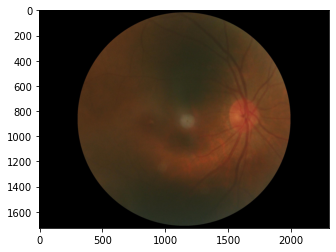

In [ ]:
plt.imshow(r_img[:,:,::-1])

clahe: (240, 240, 3)


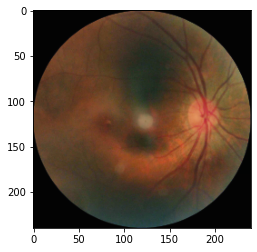

In [ ]:
plt.imshow(create_clahe(r_img)[:, :, ::-1])

new full images shape: 
(1, 241, 241, 1)
29/29 [==============================] - 1s 40ms/step
N_patches_h: 30
N_patches_w: 30
N_patches_img: 900
According to the dimension inserted, there are 1 full images (of 241x241 each)
900 900
using avg
(240, 240)


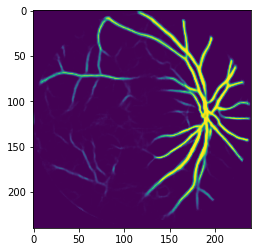

In [ ]:
vessel_img = create_vessel(r_img)
print(vessel_img.shape)
plt.imshow(vessel_img)

(584, 565, 3)


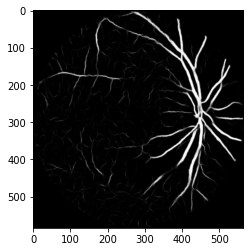

In [ ]:
vessel_0_r = cv2.imread('/content/drive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/data/vessel-train-full/0_right.jpg')
print(vessel_0_r.shape)
plt.imshow(vessel_0_r)

In [ ]:
from albumentations import (
    HorizontalFlip, VerticalFlip, CenterCrop, RandomRotate90, RandomCrop, 
    PadIfNeeded, Normalize, Flip, OneOf, Compose, Resize, Transpose, 
    IAAAdditiveGaussianNoise, GaussNoise, CLAHE, RandomBrightnessContrast, HueSaturationValue,
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)

In [ ]:
def aug_train_heavy(resolution, p=1.0):
  return Compose([
      Resize(resolution,resolution),
      OneOf([RandomRotate90(),Flip(),Transpose(),HorizontalFlip(),VerticalFlip()],p=1.0),
      OneOf([
          IAAAdditiveGaussianNoise(),
          GaussNoise(),
      ], p=0.5),
      OneOf([
          MotionBlur(p=.2),
          MedianBlur(blur_limit=3, p=0.1),
          Blur(blur_limit=3, p=0.1),
      ], p=0.2),
      ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
      OneOf([
          OpticalDistortion(p=0.3),
          GridDistortion(p=.1),
          IAAPiecewiseAffine(p=0.3),
      ], p=0.1),
      OneOf([
          CLAHE(clip_limit=2),
          IAASharpen(),
          IAAEmboss(),
          RandomBrightnessContrast(),            
      ], p=0.3),
      HueSaturationValue(p=0.3),
      Normalize()
  ], p=p)

In [ ]:
aug = aug_train_heavy(240)

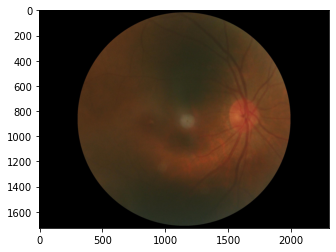

In [ ]:
plt.imshow(r_img[:,:,::-1])

In [ ]:
r_aug = aug(image=r_img)['image']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


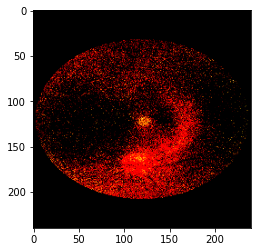

In [ ]:
plt.imshow(r_aug[:,:,::-1])